In [ ]:
#from bdshot_simulator import *

def format_nibbles(value):
    binary = format(value, '012b')  # Convert to 12-bit binary string
    return f"{binary[:4]} {binary[4:8]} {binary[8:]}"  # Add spaces for nibbles

import matplotlib.pyplot as plt
import numpy as np


def calculate_crc(value_12bit, protocol='BDShot'):
    """Calculate 4-bit CRC for a 12-bit telemetry value."""
    if not 0 <= value_12bit <= 0xFFF:
        raise ValueError(f"Input {value_12bit} exceeds 12-bit range")
    if protocol == 'BDShot':
        value_16bit = value_12bit << 4
        csum = value_16bit
        csum ^= csum >> 8
        csum ^= csum >> 4
        return (~csum & 0xF)
    elif protocol == 'DShot':
        value = value_12bit
        crc = value ^ (value >> 4) ^ (value >> 8)
        return (~crc & 0xF)
    else:
        raise ValueError(f"Unsupported protocol: {protocol}")

def check_crc(value_16bit, protocol='BDShot'):
    """Check CRC validity of a 16-bit telemetry value."""
    if not 0 <= value_16bit <= 0xFFFF:
        raise ValueError(f"Input {value_16bit} exceeds 16-bit range")
    if protocol == 'BDShot':
        csum = value_16bit
        csum ^= csum >> 8
        csum ^= csum >> 4
        return (csum & 0xF) == 0xF
    elif protocol == 'DShot':
        value_12bit = value_16bit >> 4
        crc = value_16bit & 0xF
        expected_crc = value_12bit ^ (value_12bit >> 4) ^ (value_12bit >> 8)
        return (crc == (~expected_crc & 0xF))
    else:
        raise ValueError(f"Unsupported protocol: {protocol}")

def extract_throttle(packet_12bit: int) -> int:
    """
    Extracts the throttle value (base-10) from a 12-bit DShot/BDShot packet.

    :param packet_12bit: A 12-bit integer (throttle + telemetry)
    :return: Integer throttle value (0 to 2047)
    """
    assert 0 <= packet_12bit < (1 << 12), "Input must be a 12-bit value"
    return packet_12bit >> 1


def make_bdshot_packet(throttle: int, telemetry: int) -> int:
    """
    Construct the 12-bit BDShot packet from throttle and telemetry flag.

    :param throttle: Throttle value (0–2047)
    :param telemetry: Telemetry flag (0 or 1)
    :return: 12-bit integer representing the packet (11 throttle bits + 1 telemetry bit)
    """
    if not (0 <= throttle <= 2047):
        raise ValueError("Throttle must be between 0 and 2047")
    if telemetry not in (0, 1):
        raise ValueError("Telemetry must be 0 or 1")

    return (throttle << 1) | telemetry


def format_nibbles(value):
    binary = format(value, '012b')  # Convert to 12-bit binary string
    return f"{binary[:4]} {binary[4:8]} {binary[8:]}"  # Add spaces for nibbles

def plot_bdshot_packet_waveform(packet_12bit: int):
    """
    Plot BDShot waveform using PWM-style digital signaling:
    - Each bit slot starts HIGH
    - Drops LOW for a short (0) or long (1) duration
    - Returns to HIGH for the rest of the bit slot
    """
    if not (0 <= packet_12bit < (1 << 12)):
        raise ValueError("Input must be a 12-bit value (0–4095)")
    crc = calculate_crc(packet_12bit)
    packet_16 = (packet_12bit << 4) | crc

    bits = [(packet_16 >> i) & 1 for i in reversed(range(16))]

    # Timing settings (normalized units)
    short_pulse = 0.3  # LOW time for bit 0
    long_pulse = 0.7   # LOW time for bit 1

    # Build waveform
    t = [0.0, 0.5]
    v = [1, 1]  # start HIGH

    for i, bit in enumerate(bits):
        start = t[-1]
        pulse = long_pulse if bit == 1 else short_pulse
        end_low = start + pulse
        end_bit = start + 1.0

        # Drop to LOW
        t += [start, end_low]
        v += [0, 0]

        # Return to HIGH
        t += [end_low, end_bit]
        v += [1, 1]

    # Plot
    plt.figure(figsize=(14, 3))
    plt.step(t, v, where='post', linewidth=2, color='black')
    plt.ylim(-0.5, 1.5)
    plt.yticks([0, 1], ["LOW", "HIGH"])
    bit_positions = np.arange(0.5, len(bits), 1.0)
    plt.xticks(bit_positions, [f"{i}" for i in range(1,17)])
    plt.grid(True, axis='x', linestyle=':', color='gray')

    packet_16_formatted = format(packet_16, '016b')
    packet_16_formatted = f"{packet_16_formatted[:4]} {packet_16_formatted[4:8]} {packet_16_formatted[8:12]} {packet_16_formatted[12:]}"
    plt.title(f"BDShot PWM Waveform for Packet={packet_16_formatted}")
    plt.xlabel("Bit Position (MSB → LSB)")
    plt.tight_layout()
    plt.show()

def decode_gcr_mapping(value: int) -> int:
    """
    Decodes a 20 bit GCR encoded value that has been mapped to 21 bits.
    Start with a 21 bit value and returns a 20 bit GCR
    Also seems to work when given a 20 bit value (by excluding the first "starting" bit)
    """
    gcr = (value ^ (value >> 1))
    return gcr

def decode_gcr_20_to_16(binary_int):
    """
    Decodes a 20-bit integer composed of 4 GCR-encoded 5-bit values into a 16-bit integer
    made of the corresponding 4 original 4-bit nibbles.

    :param binary_int: Integer representing 20 bits (4 × 5-bit GCR encoded chunks)
    :return: Integer representing the 4 decoded 4-bit values (16 bits)
    """
    # GCR decoding map
    encoding_map = {
        0x0: 0x19, 0x1: 0x1B, 0x2: 0x12, 0x3: 0x13,
        0x4: 0x1D, 0x5: 0x15, 0x6: 0x16, 0x7: 0x17,
        0x8: 0x1A, 0x9: 0x09, 0xA: 0x0A, 0xB: 0x0B,
        0xC: 0x1E, 0xD: 0x0D, 0xE: 0x0E, 0xF: 0x0F
    }
    decoding_map = {v: k for k, v in encoding_map.items()}

    # Convert input to 20-bit binary string
    bin_str = f"{binary_int:020b}"

    # Split into 4 chunks of 5 bits each
    chunks = [int(bin_str[i:i+5], 2) for i in range(0, 20, 5)]

    decoded = []
    for chunk in chunks:
        if chunk not in decoding_map:
            raise ValueError(f"Invalid GCR 5-bit code: {chunk:05b}")
        decoded.append(decoding_map[chunk])

    # Combine the 4 nibbles into a 16-bit integer
    result = 0
    for nibble in decoded:
        result = (result << 4) | nibble

    return result

def parse_edt_frame(frame: int, pole_pairs: int):
    """
    Parses a 16-bit DSHOT telemetry frame. Determines if it's eRPM or EDT, validates CRC,
    and extracts period or telemetry value accordingly.

    :param frame: 16-bit integer telemetry frame (0–65535)
    :return: dict with parsed fields and values
    """
    if frame < 0 or frame > 0xFFFF:
        raise ValueError("Input must be a 16-bit integer (0 to 65535)")

    # Extract 12-bit data and 4-bit CRC
    data = (frame >> 4) & 0x0FFF
    crc_received = frame & 0x0F
    crc_calculated = calculate_crc(data)

    if crc_received != crc_calculated:
        return {"type": "invalid", "reason": "CRC mismatch"}

    # Extract exponent and base_period
    exponent = (data >> 9) & 0b111        # bits 9-11
    base_period = data & 0x1FF            # bits 0-8
    period_us = base_period << exponent   # period in microseconds

    # Detect EDT vs eRPM
    is_edt = (exponent & 1) == 0 and (base_period & 0x100) == 0

    if is_edt:
        telemetry_type = (data >> 8) & 0xF
        telemetry_value = data & 0xFF

        type_names = {
            0x02: "Temperature (°C)",
            0x04: "Voltage (V)",
            0x06: "Current (A)",
            0x08: "Debug 1",
            0x0A: "Debug 2",
            0x0C: "Stress Level",
            0x0E: "Status Frame"
        }

        type_label = type_names.get(telemetry_type, f"Unknown (0x{telemetry_type:X})")

        # Scale/interpret telemetry values
        if telemetry_type == 0x04:  # Voltage
            telemetry_value = round(telemetry_value * 0.25, 2)
        elif telemetry_type == 0x0E:  # Status Frame
            telemetry_value = {
                "alert": bool(telemetry_value & 0x80),
                "warning": bool(telemetry_value & 0x40),
                "error": bool(telemetry_value & 0x20),
                "stress_max": telemetry_value & 0x0F
            }

        return {
            "type": "EDT",
            "subtype": type_label,
            "value": telemetry_value,
            "raw_frame": frame,
            "crc_valid": True
        }

    else:
        # Treat maximum period (base_period = 0x1FF) as zero RPM
        if base_period == 0 or base_period == 0x1FF:
            erpm = 0
        else:
            erpm = 60_000_000 / period_us

        return {
            "type": "eRPM",
            "base_period": base_period,
            "exponent": exponent,
            "period_us": period_us,
            "eRPM": round(erpm, 2),
            "motor_rpm": round(erpm / pole_pairs, 2),  # optional RPM conversion
            "raw_frame": frame,
            "crc_valid": True
        }


12-bit packet: 0000 0000 0110
CRC: 1001
Throttle: 3


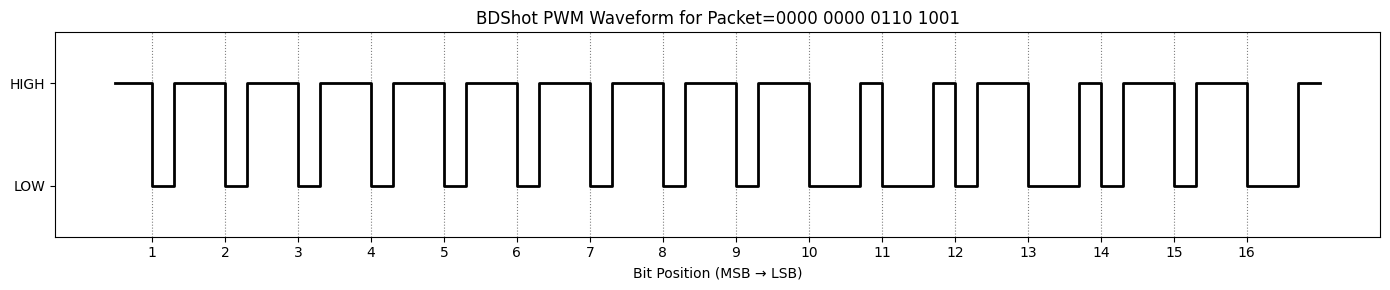

In [10]:
# Example usage:
packet_12bit = make_bdshot_packet(extract_throttle(0b000000000110), 0) #Binary 12 bit packet
print(f"12-bit packet: {format_nibbles(packet_12bit)}")

crc = calculate_crc(packet_12bit)
throttle = extract_throttle(packet_12bit)

print(f"CRC: {crc:04b}")
print(f"Throttle: {throttle}")

plot_bdshot_packet_waveform(packet_12bit)


In [11]:
values = {
    "0" : ["01010 01010 01010 10001"],
    "1217-1233" : ["01101 01110 11100 11011", 
                   "01101 01110 10001 01001"],
    "3950-4000" : ["11010 11101 01011 00101", 
                   "11010 11101 10001 00011"],
    "8400-8600" : ["11001 00011 00101 10101", 
                   "11001 00011 00100 01011"],
    "17500" : ["11101 01101 10101 00011"],
    "717" : ["01101 10010 11001 10011", 
             "01101 10010 10110 01101"],
    "2033-2050" : ["01110 11101 00100 11101",
                    "01110 11101 00010 11011"],
    "4700" : ["11010 10001 00110 01001",
              "11010 10001 00110 01001"],
    "14500" : ["11101 00110 11011 10101",
               "11101 00110 01100 11101"],
    "20700" : ["10010 01011 00011 00011",
               "10010 01001 10101 01011"]
}

for key, value in values.items():
    for v in value:
        v = int(v.replace(" ", ""), 2)
        result = parse_edt_frame(decode_gcr_20_to_16(decode_gcr_mapping(v)), 6)
        motor_rpm = result.get("motor_rpm") if result.get("type") == "eRPM" else "Invalid CRC"
        print(f"Expected RPM: {key}, Decoded: {motor_rpm}")
    print("\n")

Expected RPM: 0, Decoded: 0.0


Expected RPM: 1217-1233, Decoded: 1211.24
Expected RPM: 1217-1233, Decoded: 1220.7


Expected RPM: 3950-4000, Decoded: 3955.7
Expected RPM: 3950-4000, Decoded: 3993.61


Expected RPM: 8400-8600, Decoded: 8474.58
Expected RPM: 8400-8600, Decoded: 8503.4


Expected RPM: 17500, Decoded: 17421.6


Expected RPM: 717, Decoded: 715.1
Expected RPM: 717, Decoded: 716.74


Expected RPM: 2033-2050, Decoded: 2016.13
Expected RPM: 2033-2050, Decoded: 2035.83


Expected RPM: 4700, Decoded: 4789.27
Expected RPM: 4700, Decoded: 4789.27


Expected RPM: 14500, Decoded: 14619.88
Expected RPM: 14500, Decoded: 14450.87


Expected RPM: 20700, Decoded: 20746.89
Expected RPM: 20700, Decoded: 20876.83




In [31]:
value = int("11010010010010011101".replace(" ",""),2)
print(f"GCR Mapped: {value:021b}")
gcr = decode_gcr_mapping(value)
print(f"GCR: {gcr:021b}")
telemetry = decode_gcr_20_to_16(gcr)
print(f"Telemetry: {telemetry:016b}")
print(telemetry)
parse_edt_frame(telemetry, 7)
#read_value_from_16bit(telemetry)

GCR Mapped: 011010010010010011101
GCR: 010111011011011010011
Telemetry: 0111110101100011
32099


{'type': 'eRPM',
 'base_period': 470,
 'exponent': 3,
 'period_us': 3760,
 'eRPM': 15957.45,
 'motor_rpm': 2279.64,
 'raw_frame': 32099,
 'crc_valid': True}